In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt

# from shapely.geometry import shape, Point
# import pandas as pd
import json

# be mindful of "-83.61155885,"

Initially, sensor data in csv format is inputted and converted to a pandas dataframe (df). The df must include a "Latitude, Longitude" column, which specifies the exact coordinates of the sensor location. All NaN sensor "Latitude, Longitude" values are then filtered out, resulting in only valid coordinate pairs remaining for each unique sensor. The "Latitude, Longitude" column in split into 2 columns "lat" and "lon", respectively, and converted to floats (to handle possible conversion errors later).

All sensors from the df are filtered to include only water depth sensors (which are distinctive as their "Site ID" starts with an "A"). Further error handling is performed to remove any rows with NaN "lat" and "lon" values. The df is stored as a new "df_filtered" and stored to csv format for reference ("filtered_sensor_data.csv"). Geopandas is used to convert "df_filtered" to a GeoDataFrame and store as a geojson ("Test_Huron_Watershed_Sensors.geojson").

In [9]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Locations-grafana.csv')

# Determine how many rows of "Latitude, Longitude" there are
print("Total number of 'Latitude, Longitude' rows there are: " + str(len(df['Latitude, Longitude'])) + "\n")

# Split 'Latitude, Longitude' into separate columns
df = df.dropna(subset=['Latitude, Longitude'])

df[['lat', 'lon']] = df['Latitude, Longitude'].str.split(', ', expand=True)

# Determine length of lat and lon columns now (should be equal)
print("Testing if 'lat' and 'lon' are equal in length:")
print("'lat' length = " + str(len(df['lat'])) + " and 'lon' length = " + str(len(df['lon'])) + "\n")

# Convert 'lat' and 'lon' to float, handling possible errors
df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
df['lon'] = pd.to_numeric(df['lon'], errors='coerce')

# Filter rows where Site ID starts with 'A' and drop rows with NaN longitude or latitude
df_filtered = df[df['Site ID'].str.startswith('A') & 
                 ~df['lon'].isna() &
                 ~df['lat'].isna()]

# Determine length of lat and lon columns now (should be equal)
print("Testing if 'lat' and 'lon' are equal in length:")
print("'lat' length = " + str(len(df['lat'])) + " and 'lon' length = " + str(len(df['lon'])) + "\n") #print(len(df['lon']))

# Save the filtered DataFrame back to a CSV file
df_filtered.to_csv('filtered_sensor_data.csv', index=False)

# Create a GeoDataFrame for spatial operations
geometry = [Point(lon, lat) for lon, lat in zip(df_filtered['lon'], df_filtered['lat'])]
# geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = {'init': 'epsg:4326'}  # assuming WGS84 coordinates
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs=crs)

# Convert to GeoJSON
output_geojson = 'Test_Huron_Watershed_Sensors.geojson'
gdf.to_file(output_geojson, driver='GeoJSON')

Total number of 'Latitude, Longitude' rows there are: 311

Testing if 'lat' and 'lon' are equal in length:
'lat' length = 278 and 'lon' length = 278

Testing if 'lat' and 'lon' are equal in length:
'lat' length = 278 and 'lon' length = 278



/Users/shinapatel/anaconda3/envs/geo_env/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Here, the polygon shape from the "Huron_Watershed.geojson" is plotted. This is done by inputting the Huron River Watershed area in the form of a .geojson file, which is then converted into a GeoDataFrame using GeoPandas.

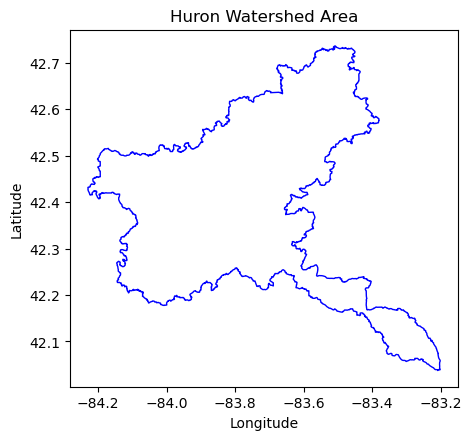

In [10]:
# Input is in the form of a .geojson file and converted into a GeoDataFrame using GeoPandas
file_path = "Huron_Watershed.geojson"
gdf = gpd.read_file(file_path)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor='none', edgecolor='blue')  # Adjust colors as desired
ax.set_title('Huron Watershed Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Now, we will plot all of the sensors and the Huron River on top of the Huron River Watershed plot. Note that this is without any filtration and is done so simply for reference/comparison purposes. 

Initially, all 3 relevant .geojson file such as the 'Test_Huron_Watershed_Sensors.geojson' (representing the filtered water depth sensors), 'Huron_RiverSystem.geojson' (representing the Huron River), and the 'Huron_Watershed.geojson' (representing the Huron River Watershed) are loaded into GeoDataFrames (gpd) using GeoPandas. All 3 gpd's are plotted onto the same plot, resulting in the following image seen below. 

Text(77.95625524543912, 0.5, 'Latitude')

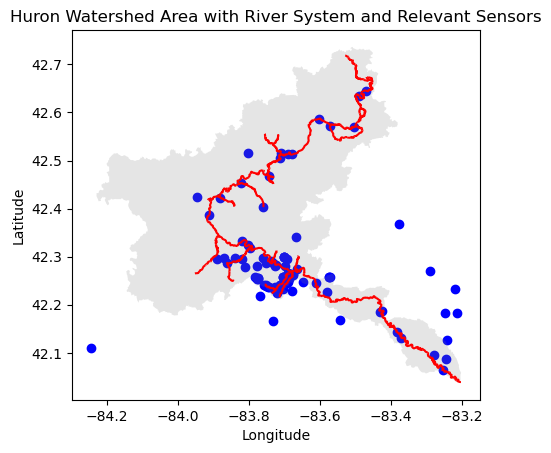

In [11]:
# Load GeoJSON files into GeoDataFrames
sensor_file = 'Test_Huron_Watershed_Sensors.geojson'
river_file = 'Huron_RiverSystem.geojson'
watershed_file = 'Huron_Watershed.geojson'

sensor = gpd.read_file(sensor_file)
river = gpd.read_file(river_file)
watershed = gpd.read_file(watershed_file)

# Plot GeoDataFrames on the same plot
ax = sensor.plot(color='blue', label='DWL @ UM sensors')
ax.set_title('Huron Watershed Area with River System and Relevant Sensors')
river.plot(ax=ax, color='red', label='Rivers')
watershed.plot(ax=ax, color='gray', label='Watershed', alpha = 0.2)

# Add legends and labels
# ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')



The following demonstrates a broader version of filtration which removes any sensors that are not located within the Huron River Watershed.

This is achieved by initially reading in the relevant 'Huron_Watershed.geojson' as a GeoDataFrame (gpd). The .geojson file is stored as "watershed_file" and the gpd is stored as "watershed_gdf". Next, the relevant 'filtered_sensor_data.csv' (from the initial steps) is loaded under "sensors_file" and converted to a Pandas dataframe under "sensors_df". 

Using shapely.geometry, the "sensors_df" file (which contains a 'lat' and 'lon' column from splitting the "Latitude, Longitude" column earlier) stores the longitude and latitude value of each unique sensor as a pair and creates a Point object of each. The final result is a GeoDataFrame "sensors_gdf" where each row contains the original sensor data along with a geometry column specifying the location of each sensor. This GeoDataFrame can be used for various geospatial operations and visualizations. (Note: crs='EPSG:4326' is the standard for latitude and longitude coordinates). As for the Huron River Watershed, using the shape library from shapely.geometry, the "watershed_gdf" is converted into a watershed polygon. This polygon shape is stored as "huron_watershed_polygon". 

Next, the filtration step using shapely.geometry occurs where any sensor that intersects with the Huron River Watershed polygon is stored into a .geojson file "sensors_within_huron_watershed.geojson" and csv file "sensors_within_huron_watershed.csv". 

Thus, the "sensors_within_huron_watershed.geojson" and "sensors_within_huron_watershed.csv" files contain only sensor locations located within the Huron River Watershed area.

  Site ID Node ID  Distance from Node to Ground (mm)  \
0  A2DWTP     NaN                                NaN   
1  ARB001     NaN                                0.0   
2  ARB002    097A                             1562.1   
3  ARB003    094A                             1905.0   
5  ARB005     NaN                                3.0   

                                             Grafana  \
0  http://ec2-3-142-80-107.us-east-2.compute.amaz...   
1                                                NaN   
2  https://dash.digitalwaterlab.org:3000/d/yE7jC5...   
3  https://dash.digitalwaterlab.org:3000/d/V5X9ip...   
5                                                NaN   

                                  Site Name Date Deployed        Project  \
0  Ann Arbor Drinking Water Treatment Plant     10/7/2021        BlueSky   
1                             Michigan Aero      6/3/2016            NaN   
2                     Ellsworth South Inlet      6/3/2016  Washtenaw Co.   
3                    E

Text(81.14811467980415, 0.5, 'Latitude')

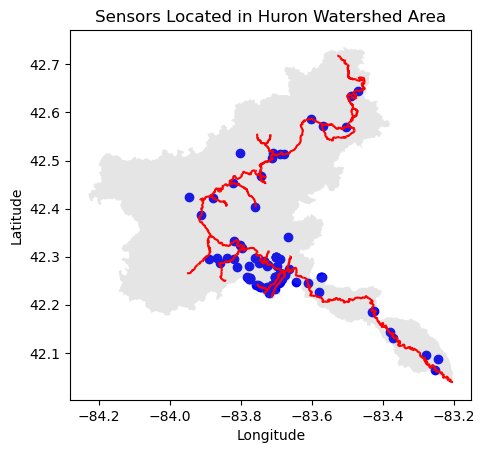

In [12]:
# Loading Watershed files
watershed_file = 'Huron_Watershed.geojson'
watershed_gdf = gpd.read_file(watershed_file)

# Loading Sensor files
sensors_file = 'filtered_sensor_data.csv'
sensors_df = pd.read_csv(sensors_file)

# Converting csv of sensor file to gpd (must have 'lat' and 'lon' column as done earlier)
sensors_geometry = [Point(xy) for xy in zip(sensors_df.lon, sensors_df.lat)]
sensors_gdf = gpd.GeoDataFrame(sensors_df, crs='EPSG:4326', geometry=sensors_geometry)

# Converting the Huron River watershed polygon to Shapely geometry
huron_watershed_polygon = shape(watershed_gdf.geometry.iloc[0])

# Filter sensors that intersect with the Huron River watershed polygon
sensors_within_watershed = sensors_gdf[sensors_gdf.geometry.apply(lambda x: x.intersects(huron_watershed_polygon))]

# Print and save the filtered sensors
print(sensors_within_watershed.head())
output_file = 'sensors_within_huron_watershed.geojson'
output_csv_file = 'sensors_within_huron_watershed.csv'
sensors_within_watershed.to_file(output_file, driver='GeoJSON')
sensors_within_watershed.to_csv(output_csv_file, index='False')



# Load GeoJSON files into GeoDataFrames
sensor_file = 'sensors_within_huron_watershed.geojson'
river_file = 'Huron_RiverSystem.geojson'
watershed_file = 'Huron_Watershed.geojson'

sensor = gpd.read_file(sensor_file)
river = gpd.read_file(river_file)
watershed = gpd.read_file(watershed_file)

# Plot GeoDataFrames on the same plot
ax = sensor.plot(color='blue', label='DWL @ UM sensors')
river.plot(ax=ax, color='red', label='Rivers')
watershed.plot(ax=ax, color='gray', label='Watershed', alpha = 0.2)

# Add title, labels
# ax.legend()
ax.set_title("Sensors Located in Huron Watershed Area")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


The following demonstrates a narrower version of filtration which removes any sensors that are not located close to the Huron River.

Similar to the broader filtration steps outlined above, the 'Huron_RiverSystem.geojson' is loaded as a GeoDataFrame (gpd). The .geojson file is stored as "river_file" and the gpd is stored as "river_gdf". Next, the relevant 'filtered_sensor_data.csv' (from the initial steps) is loaded under "sensors_file" and converted to a Pandas dataframe under "sensors_df".

Once again, the steps from above are followed using shapely.geometry, to result in a GeoDataFrame "sensors_gdf" where each row contains the original sensor data along with a geometry column specifying the location of each sensor. This GeoDataFrame can be used for various geospatial operations and visualizations. 
(Note: crs='EPSG:4326' is the standard for latitude and longitude coordinates). 

Next, using shapely.geometry, a buffer of size 0.01 is created, representing a margin of acceptable sensor distance from the Huron River System. The filtration step occurs where spatial join (.sjoin) is used to remove any sensors that are not located near the Huron River. The acceptable sensors are saved under "sensors_near_river".

Finally, "sensors_near_river" is stored into a new GeoJSON file as 'sensors_near_river.geojson', which contains only sensor locations located near the Huron River.

In [13]:
# Load sensor data from CSV or GeoJSON
sensors_file = 'filtered_sensor_data.csv'
sensors_df = pd.read_csv(sensors_file)


# Convert CSV data to GeoDataFrame assuming columns 'lon' and 'lat'
sensors_geometry = [Point(xy) for xy in zip(sensors_df.lon, sensors_df.lat)]
sensors_gdf = gpd.GeoDataFrame(sensors_df, crs='EPSG:4326', geometry=sensors_geometry)

# Load river data from GeoJSON
river_file = 'Huron_RiverSystem.geojson'
river_gdf = gpd.read_file(river_file)

# Buffer (= 0.01) the river (treated as a line)
buffer_distance = 0.01  # Adjust as needed based on your data's CRS
river_gdf['geometry'] = river_gdf.geometry.buffer(buffer_distance)

# Perform spatial join to find sensors near the river
sensors_near_river = gpd.sjoin(sensors_gdf, river_gdf, how='inner', predicate='intersects')

# Save sensors_near_river as a new GeoJSON file
output_geojson = 'sensors_near_river.geojson'
sensors_near_river.to_file(output_geojson, driver='GeoJSON')

# Code to plot the filtered sensors
# # Step 5: Plot filtered sensors and river
# ax = sensors_near_river.plot(color='blue', markersize=5, label='Sensors near river')
# river_gdf.plot(ax=ax, color='red', alpha=0.5, label='Huron River')

# # Add legends and labels
# ax.legend()
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

/var/folders/22/yp41wl3d2pd0d9b4zcdlnb380000gn/T/ipykernel_67956/3640098481.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_gdf['geometry'] = river_gdf.geometry.buffer(buffer_distance)
/var/folders/22/yp41wl3d2pd0d9b4zcdlnb380000gn/T/ipykernel_67956/3640098481.py:19: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  sensors_near_river = gpd.sjoin(sensors_gdf, river_gdf, how='inner', predicate='intersects')


Now that the final list of relevant sensors (which are located near the Huron River) is developed through the filtration steps above, we can plot them to visually ensure that successful filtration has occured.

First, 'sensors_near_river.geojson' (representing the sensors near the Huron River), 'Huron_RiverSystem.geojson' (representing the Huron River System), and 'Huron_Watershed.geojson' (representing the Huron Watershed) are loaded into GeoDataFrames (gpd) as "sensor", "river", and "watershed", respectively. All 3 files are then plotted ontop of the same plot as outputted below.

Text(81.14811467980415, 0.5, 'Latitude')

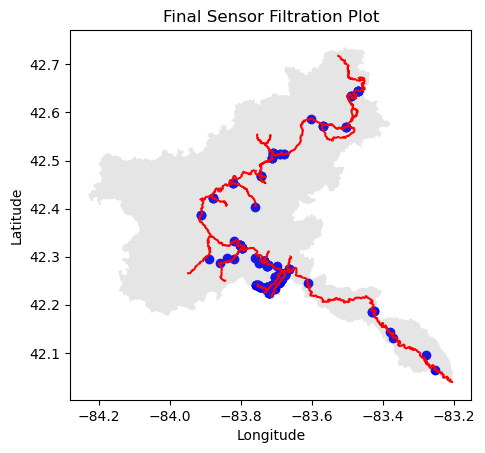

In [14]:
# Load GeoJSON files into GeoDataFrames
sensor_file = 'sensors_near_river.geojson'
river_file = 'Huron_RiverSystem.geojson'
watershed_file = 'Huron_Watershed.geojson'

sensor = gpd.read_file(sensor_file)
river = gpd.read_file(river_file)
watershed = gpd.read_file(watershed_file)

# Plot GeoDataFrames on the same plot
ax = sensor.plot(color='blue', label='DWL @ UM sensors')
river.plot(ax=ax, color='red', label='Rivers')
watershed.plot(ax=ax, color='gray', label='Watershed', alpha = 0.2)

# Add title, labels
# ax.legend()
ax.set_title("Final Sensor Filtration Plot")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# all sensors in the watershed
# on the river (buffer = 0.001)
# near the river (buffer = 0.01)
# sensors purely near the river
# have all sensors in watershed and filter out any near ones